**Import necessary libraries**

In [1]:
import numpy as np
import os
import cv2
from keras_tuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**Prepare dataset**

In [2]:
# Define directory path
path_dir = 'UTKFace'

# Display total images in dataset
print(len(os.listdir(path_dir)))

23708


In [3]:
# Check naming
print(os.listdir(path_dir)[:10])

['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg', '100_1_0_20170112213001988.jpg.chip.jpg', '100_1_0_20170112213303693.jpg.chip.jpg', '100_1_0_20170112215032192.jpg.chip.jpg', '100_1_0_20170117195420803.jpg.chip.jpg', '100_1_0_20170119212053665.jpg.chip.jpg', '100_1_2_20170105174847679.jpg.chip.jpg', '100_1_2_20170112213615815.jpg.chip.jpg']


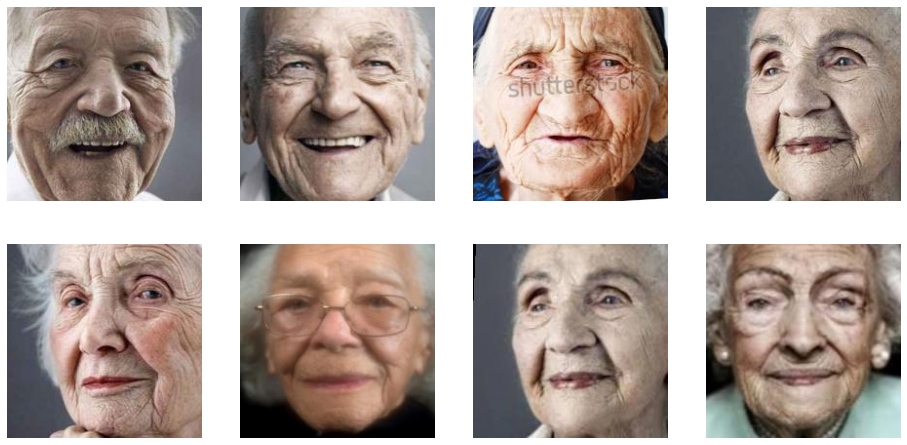

In [3]:
# Display image sample
nrows = 2
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_img = [os.path.join(path_dir, fname) 
                for fname in os.listdir(path_dir)[0:8]]

for i, img_path in enumerate(next_img):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [3]:
# Gather images into pixels and labels into gender
pixels = []
gender = []
for f in os.listdir(path_dir):
  genders = f.split("_")[1]
  img = cv2.imread(str(path_dir)+"/"+str(f))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pixels.append(np.array(img))
  gender.append(np.array(genders))
pixels = np.array(pixels)
gender = np.array(gender, np.uint8)

In [4]:
# Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(
    pixels, gender, test_size=0.05, 
    random_state=100, stratify=gender)

In [7]:
# Display total images for train and test
print('total train images:', len(x_train))
print('total test images:', len(x_test))

total train images: 22522
total test images: 1186


In [8]:
# Display shape
print("Train Data  :", x_train.shape)
print("Train Label :", y_train.shape)
print("Test Data   :", x_test.shape)
print("Test Label  :", y_test.shape)

Train Data  : (22522, 200, 200, 3)
Train Label : (22522,)
Test Data   : (1186, 200, 200, 3)
Test Label  : (1186,)


**Hyperparameter tuning**

In [5]:
# build model
def build_model(hp):
  model = Sequential()
  
  model.add(InputLayer(input_shape=(200, 200, 3)))
  model.add(Conv2D(filters=hp.Int("conv_1", min_value=16, max_value=64, step=16), kernel_size=3, padding="same", activation="relu"))
  model.add(MaxPool2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(filters=hp.Int("conv_2", min_value=16, max_value=64, step=16), kernel_size=3, padding="same", activation="relu"))
  model.add(MaxPool2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(filters=hp.Int("conv_3", min_value=16, max_value=64, step=16), kernel_size=3, padding="same", activation="relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(units=hp.Int("dense", min_value=96, max_value=128, step=16), activation="relu"))
  model.add(Dense(1, activation="sigmoid"))
  
  model.compile(optimizer=Adam(
      learning_rate=hp.Choice("learning_rate", values=[1e-3, 1e-4])),
      loss="binary_crossentropy",
      metrics=["acc"])
  
  return model

In [6]:
tuner = Hyperband(
    build_model,
    objective='val_acc',
    max_epochs=3,
    factor=3,
    project_name="tuner")

tuner.search(
    x_train, y_train, validation_split=0.2, 
    callbacks=[EarlyStopping(monitor="val_loss", patience=2)])

Trial 6 Complete [00h 41m 22s]
val_acc: 0.871032178401947

Best val_acc So Far: 0.871032178401947
Total elapsed time: 02h 08m 31s
INFO:tensorflow:Oracle triggered exit


In [27]:
best_hps = tuner.get_best_hyperparameters(num_trials=2)[1]

In [29]:
model = tuner.hypermodel.build(best_hps)

In [30]:
callback = [ModelCheckpoint(filepath="saved/best_model.h5", monitor="val_loss", save_best_only=True)]

history = model.fit(
    x_train, y_train, 
    epochs=10, 
    validation_split=0.2,
    callbacks=callback)

Epoch 1/10
564/564 [==============================] - 472s 829ms/step - loss: 0.4631 - acc: 0.7976 - val_loss: 0.3950 - val_acc: 0.8340
Epoch 2/10
564/564 [==============================] - 488s 865ms/step - loss: 0.3215 - acc: 0.8567 - val_loss: 0.3931 - val_acc: 0.8471
Epoch 3/10
564/564 [==============================] - 479s 850ms/step - loss: 0.2926 - acc: 0.8686 - val_loss: 0.3116 - val_acc: 0.8653
Epoch 4/10
564/564 [==============================] - 511s 905ms/step - loss: 0.2589 - acc: 0.8858 - val_loss: 0.3340 - val_acc: 0.8681
Epoch 5/10
564/564 [==============================] - 527s 934ms/step - loss: 0.2450 - acc: 0.8939 - val_loss: 0.3270 - val_acc: 0.8721
Epoch 6/10
564/564 [==============================] - 522s 926ms/step - loss: 0.2162 - acc: 0.9090 - val_loss: 0.3246 - val_acc: 0.8750
Epoch 7/10
564/564 [==============================] - 475s 842ms/step - loss: 0.2001 - acc: 0.9175 - val_loss: 0.3604 - val_acc: 0.8653
Epoch 8/10
564/564 [============================

**Evaluation**

In [9]:
def eval_plot(epochs):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

  ax1.plot(np.arange(0, epochs), history.history["acc"], label="train_acc")
  ax1.plot(np.arange(0, epochs), history.history["val_acc"], label="val_acc")
  ax1.set_title('Acc Result Plot')
  ax1.set(xlabel='Epoch #', ylabel='Acc')
  ax1.legend(loc="lower right")

  ax2.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
  ax2.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
  ax2.set_title('Loss Result Plot')
  ax2.set(xlabel='Epoch #', ylabel='Loss')
  ax2.legend(loc="upper right")

  fig.savefig("acc_loss_plot.svg", format="svg")

  plt.show()

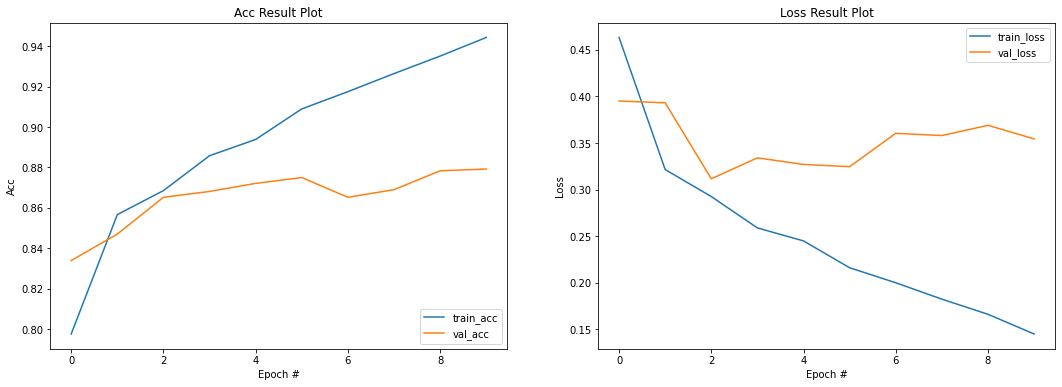

In [32]:
eval_plot(10)

In [33]:
loaded_model = load_model("saved/best_model.h5")

In [34]:
eval_result = loaded_model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

38/38 [==============================] - 17s 320ms/step - loss: 0.3160 - acc: 0.8668
[test loss, test accuracy]: [0.3159521520137787, 0.866779088973999]


In [35]:
from sklearn.metrics import classification_report

pred = loaded_model.predict(x_test)
y_pred = (pred > 0.5).astype(np.int32)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       620
           1       0.88      0.84      0.86       566

    accuracy                           0.87      1186
   macro avg       0.87      0.87      0.87      1186
weighted avg       0.87      0.87      0.87      1186



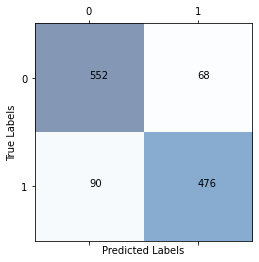

In [36]:
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(cf_matrix, cmap=plt.cm.Blues, alpha=.5)
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        ax.text(x=j, y=i, s=cf_matrix[i, j])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Prediction**

In [42]:
def predictFunc(path):
  labels = ['male', 'female']
  img_upload = Image.open(path)

  img = np.array(img_upload)
  img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, model.layers[0].output_shape[1:3])
  img = img.astype('float32')/255  
  img = np.expand_dims(img, axis=0)
  # img = img.reshape(1, 150, 150, 1)
  pred = loaded_model.predict(img)[0]
  index_label = int(np.where(pred==max(pred))[0])

  label_pred = labels[index_label]
  pred_prob = str(pred[index_label])

  return label_pred, pred_prob

Predicted Label : male
Probability : 0.12961379


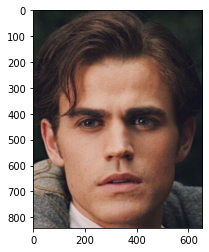

In [43]:
predict_path = 'test-images/test-img-paul.jpg'
img_upload = Image.open(predict_path)

lbl, prob = predictFunc(predict_path)
print('Predicted Label :', lbl)
print('Probability :', prob)

img_plt = plt.imshow(img_upload)
plt.show()



---

